In [2]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable
     |███████████▊                    | 325.8 MB 168.2 MB/s eta 0:00:04

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |███████████████████████████▊    | 768.4 MB 163.0 MB/s eta 0:00:01

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 887.4 MB 13 kB/s 
     |████████████████████████████████| 849 kB 130.8 MB/s eta 0:00:01
     |███████████████████████████▍    | 271.6 MB 181.6 MB/s eta 0:00:01

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 317.1 MB 43 kB/s 
     |█████████████████▋              | 305.9 MB 162.2 MB/s eta 0:00:02

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 557.1 MB 19 kB/s /s eta 0:00:01
     |████████████████████████████████| 21.0 MB 122.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install pandas
#pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [5]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.utils.data as Data
from torch.autograd import Variable

from sklearn.model_selection import train_test_split

import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [3]:
!pip install torchvision

Defaulting to user installation because normal site-packages is not writeable


In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [5]:
train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download = True,
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=ToTensor(),
    download = False,
)

In [6]:
print(train_data)
print(train_data.data.size())
print(train_data.targets.size())

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])
torch.Size([60000])


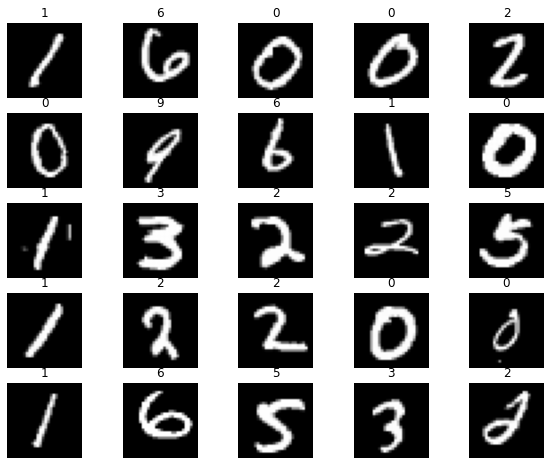

In [7]:
figure = plt.figure(figsize=(10,8))
cols, rows = 5,5
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows,cols,i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [28]:
loaders = {'train': Data.DataLoader(train_data,
                                               batch_size=20,
                                               shuffle=True,
                                               num_workers=1),
          'test': Data.DataLoader(test_data,
                                             batch_size=20,
                                             shuffle=True,
                                             num_workers=1)
          }

loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x14b6a39d3a90>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x14b6a39d3bb0>}

In [29]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1), x
    
class DNN1(nn.Module):
    def __init__(self):
        super(DNN1, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
    
    def forward(self,X):
        X = X.view(-1,784)
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1), X

In [30]:
events=8
event_weights = []

In [31]:
for event in range(events):
    cnn_models = [DNN1().to(device)]
    loss_functions = []
    optimizers = []
    num_epochs = 12

    for model in cnn_models:
        print(model)
        model.train()
        optimizers.append(optim.Adam(model.parameters(), lr = 0.01))
        loss_functions.append(nn.CrossEntropyLoss())
    model_loss=[]
    model_accuracy=[]
    model_weights = []
    model_grad_norms = []
    print('*'*20,"Event",str(event+1),'*'*20)
    for model, optimizer, loss_func in zip(cnn_models,optimizers,loss_functions):

        # Train the model
        total_step = len(loaders['train'])

        train_loss =[]
        train_acc = []
        train_grad_norm = []
        for epoch in range(num_epochs):
            correct=0
            b_loss=[]
            b_acc=[]
            b_grad_norm = []
            for i, (images, labels) in enumerate(loaders['train']):

                # gives batch data, normalize x when iterate train_loader
                b_x = Variable(images).to(device) # batch x
                b_y = Variable(labels).to(device)   # batch y
                output = model(b_x)[0]               
                loss = loss_func(output, b_y)

                # clear gradients for this training step   
                optimizer.zero_grad()           

                # backpropagation, compute gradients 
                loss.backward()    
                # apply gradients             
                optimizer.step() 

                predicted = torch.max(output.data, 1)[1]
                correct += (predicted==b_y).sum()

                b_loss.append(loss.detach().cpu().item())
                b_acc.append(float(correct)*100/float(100*(i+1)))
                
                grad_all = 0.0
                for p in model.parameters():
                    grad=0.0
                    if p.grad is not None:
                        grad = (p.grad.cpu().data.numpy() ** 2).sum()
                    grad_all +=grad
                grad_norm = grad_all**0.5
                
                b_grad_norm.append(grad_norm)

                if (i+1)%200==0 and epoch%3==0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.3f}%'.format(epoch + 1, num_epochs, i + 1, total_step, b_loss[-1],b_acc[-1]))
                    
            
            train_grad_norm.extend(b_grad_norm)
            train_loss.append(np.average(b_loss))
            train_acc.append(np.average(b_acc))

            if epoch%3==0:
#                 w_conv1 = torch.flatten(model.conv1.weight)
#                 w_conv2 = torch.flatten(model.conv2.weight)
#                 w_conv3 = torch.flatten(model.conv3.weight)
#                 w_fc1 = torch.flatten(model.fc1.weight)
#                 w_fc2 = torch.flatten(model.fc2.weight)
#                 weights = torch.cat((w_conv1,w_conv2,w_conv3,w_fc1,w_fc2),0)
                w_linear1 = torch.flatten(model.linear1.weight)
                w_linear2 = torch.flatten(model.linear2.weight)
                w_linear3 = torch.flatten(model.linear3.weight)
                weights = torch.cat((w_linear1,w_linear2,w_linear3),0)
                model_weights.append(weights)

        model_grad_norms.append(train_grad_norm)
        model_loss.append(train_loss)
        model_accuracy.append(train_acc)
        
    event_weights.extend(model_weights)

DNN1(
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)
******************** Event 1 ********************
Epoch [1/12], Step [200/3000], Loss: 0.7249, Accuracy: 16.175%
Epoch [1/12], Step [400/3000], Loss: 0.6077, Accuracy: 16.960%
Epoch [1/12], Step [600/3000], Loss: 0.3619, Accuracy: 17.410%
Epoch [1/12], Step [800/3000], Loss: 0.7877, Accuracy: 17.601%
Epoch [1/12], Step [1000/3000], Loss: 0.8880, Accuracy: 17.741%
Epoch [1/12], Step [1200/3000], Loss: 0.1210, Accuracy: 17.851%
Epoch [1/12], Step [1400/3000], Loss: 0.1056, Accuracy: 17.964%
Epoch [1/12], Step [1600/3000], Loss: 0.2003, Accuracy: 18.031%
Epoch [1/12], Step [1800/3000], Loss: 0.1228, Accuracy: 18.087%
Epoch [1/12], Step [2000/3000], Loss: 0.0130, Accuracy: 18.140%
Epoch [1/12], Step [2200/3000], Loss: 0.5357, Accuracy: 18.168%
Epoch [1/12], Step [2400/3000], Loss: 0.6147,

## HW1 : 2.1 Visualize Optimzation Process, 2.2 Observe Gradient Norm during Training

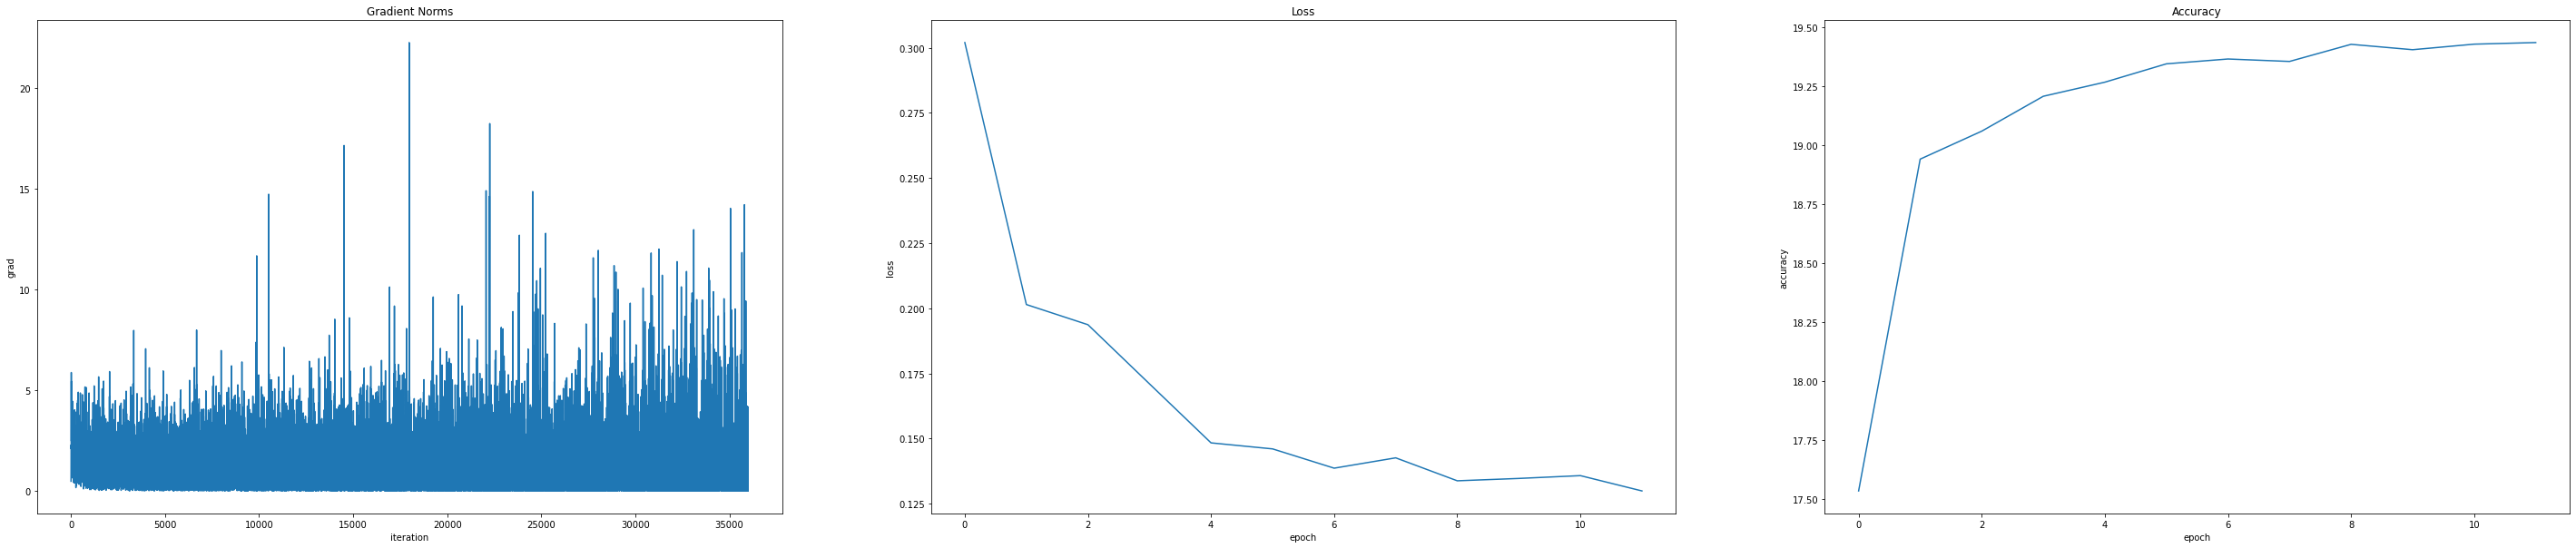

In [32]:
figure, ax= plt.subplots(1,3,figsize=(50,10))

ax[0].plot(model_grad_norms[0])
ax[0].set_title("Gradient Norms")
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("grad")

ax[1].plot(model_loss[0])
ax[1].set_title("Loss")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("loss")

ax[2].plot(model_accuracy[0])
ax[2].set_title("Accuracy")
ax[2].set_xlabel("epoch")
ax[2].set_ylabel("accuracy")

plt.show()

In [33]:
event_weights_np = np.array([ew.detach().cpu().numpy() for ew in event_weights])

In [34]:
event_weights_np.shape

(32, 222000)

In [35]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# std_df = scaler.fit_transform(event_weights_np)
# std_df.shape

In [36]:
# covar_mat = np.matmul(std_df.T, std_df)
# covar_mat.shape

In [37]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
pca_result = pca.fit_transform(event_weights_np)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
##Variance PCA: 0.993621154832802

#Run T-SNE on the PCA features.
tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(pca_result[:5000])

Variance PCA: 0.26679301261901855
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 32 samples in 0.000s...
[t-SNE] Computed neighbors for 32 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 32 / 32
[t-SNE] Mean sigma: 301.351574
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.041664
[t-SNE] KL divergence after 1000 iterations: 0.460453


/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


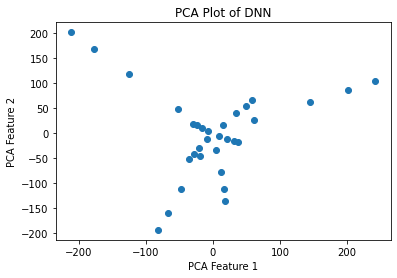

In [38]:
plt.scatter(pca_result[:,0],pca_result[:,1])
plt.title("PCA Plot of DNN")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.show()

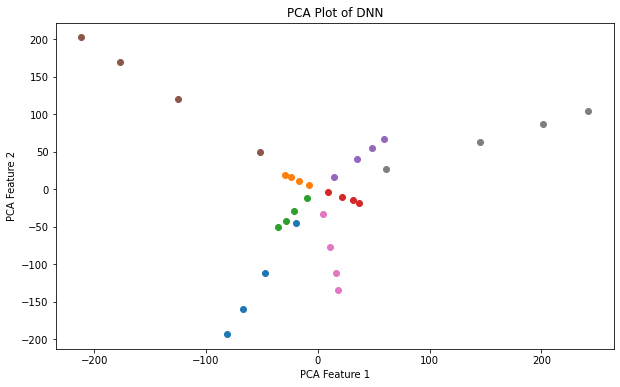

In [39]:
i=0
plt.figure(figsize=(10,6))
while i<len(pca_result):
    plt.scatter(pca_result[i:i+4,0],pca_result[i:i+4,1])
    i+=4
plt.title("PCA Plot of DNN")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.show()

Ref: https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW02/HW02-2.ipynb#scrollTo=2i8qGj2dnYBN

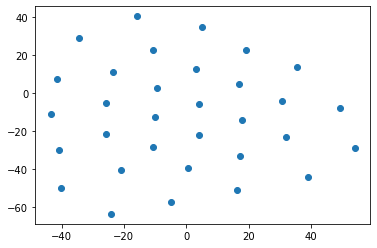

In [40]:
plt.scatter(tsne_results[:,0],tsne_results[:,1])

In [41]:
!pip install autograd-lib

Defaulting to user installation because normal site-packages is not writeable


In [44]:
import gc
import gc
def report_gpu():
   print(torch.cuda.list_gpu_processes())
   gc.collect()
   torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

## HW1 : 2.3 What Happened when Gradient is almost zero

In [45]:
from collections import defaultdict
from autograd_lib import autograd_lib

def SinFunc(x_input):
    y = (np.sin(5*math.pi*x_input))/(5*math.pi*x_input) 
    return y

X = np.linspace(1e-6, 1, 60000)
y =  SinFunc(X)

X = X.reshape(-1,1)
y = y.reshape(-1,1)

X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()

print(type(X),type(y))
print(type(X_tensor),X_tensor.shape)

model1 = torch.nn.Sequential(
            nn.Linear(1, 10),
            nn.ReLU(),
            nn.Linear(10, 18),
            nn.ReLU(),
            nn.Linear(18, 15),
            nn.ReLU(),
            nn.Linear(15, 4),
            nn.ReLU(),
            nn.Linear(4,1)
        )

class Model1(nn.Module):
    def __init__(self, num_hidden=50):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(1, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, 1)
        )

    def forward(self, x):
        x = self.regressor(x)
        return x

# autograd_lib.register(model1)

class MathRegressor(nn.Module):
    def __init__(self, num_hidden=128):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(1, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, 1)
        )

    def forward(self, x):
        x = self.regressor(x)
        return x

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'torch.Tensor'> torch.Size([60000, 1])


In [46]:
# function to compute gradient norm
def compute_gradient_norm(model, criterion, train, target):
    model.train()
    model.zero_grad()
    output = model(train)
    loss = criterion(output, target)
    loss.backward()

    grads = []
    for p in model.regressor.children():
        if isinstance(p, nn.Linear):
            param_norm = p.weight.grad.norm(2).item()
            grads.append(param_norm)

    grad_mean = np.mean(grads) # compute mean of gradient norms
    
#     grad_all = 0.0
#     for p in model.parameters():
#         grad=0.0
#         if p.grad is not None:
#             grad = (p.grad.cpu().data.numpy() ** 2).sum()
#         grad_all +=grad
#     grad_norm = grad_all**0.5
#     grad_mean = np.mean(grad_norm)

    return grad_mean,loss.item()

# helper function to save activations
def save_activations(layer, A, _):
    '''
    A is the input of the layer, we use batch size of 6 here
    layer 1: A has size of (6, 1)
    layer 2: A has size of (6, 128)
    '''
    activations[layer] = A

# helper function to compute Hessian matrix
def compute_hess(layer, _, B):
    '''
    B is the backprop value of the layer
    layer 1: B has size of (6, 128)
    layer 2: B ahs size of (6, 1)
    '''
    A = activations[layer]
    BA = torch.einsum('nl,ni->nli', B, A) # do batch-wise outer product

    # full Hessian
    hess[layer] += torch.einsum('nli,nkj->likj', BA, BA) # do batch-wise outer product, then sum over the batch
    
# function to compute the minimum ratio
def compute_minimum_ratio(model, criterion, train, target):
    model.zero_grad()
    # compute Hessian matrix
    # save the gradient of each layer
    with autograd_lib.module_hook(save_activations):
        output = model(train)
        loss = criterion(output, target)

    # compute Hessian according to the gradient value stored in the previous step
    with autograd_lib.module_hook(compute_hess):
        autograd_lib.backward_hessian(output, loss='LeastSquares')

    layer_hess = list(hess.values())
    minimum_ratio = []

    # compute eigenvalues of the Hessian matrix
    for h in layer_hess:
        size = h.shape[0] * h.shape[1]
        h = h.reshape(size, size)
        h_eig = torch.symeig(h).eigenvalues # torch.symeig() returns eigenvalues and eigenvectors of a real symmetric matrix
        num_greater = torch.sum(h_eig > 0).item()
        minimum_ratio.append(num_greater / len(h_eig))

    ratio_mean = np.mean(minimum_ratio) # compute mean of minimum ratio

    return ratio_mean

In [47]:

import gc
def report_gpu():
   print(torch.cuda.list_gpu_processes())
   gc.collect()
   torch.cuda.empty_cache()


In [48]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [49]:
# fix random seed
torch.manual_seed(42)

grad_norm_arr = []
min_ratio_arr = []
loss_arr = []

for event in range(100):
    model = Model1()
    autograd_lib.register(model)
    
    # reset compute dictionaries
    activations = defaultdict(int)
    hess = defaultdict(float)

    # compute Hessian
    # the main function to compute gradient norm and minimum ratio
    criterion = nn.MSELoss()

    gradient_norm, loss = compute_gradient_norm(model, criterion, X_tensor, y_tensor)
    minimum_ratio = compute_minimum_ratio(model, criterion, X_tensor, y_tensor)

    grad_norm_arr.append(gradient_norm)
    min_ratio_arr.append(minimum_ratio)
    loss_arr.append(loss)
    
    if event%10==0:
        print('Event: {}, gradient norm: {}, minimum ratio: {}, loss: {}'.format(event,gradient_norm, minimum_ratio,loss))

/home/gpisal/.local/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Event: 0, gradient norm: 1.6987058967351913, minimum ratio: 0.55, loss: 0.3136012554168701
Event: 10, gradient norm: 1.1226134449243546, minimum ratio: 0.74, loss: 0.277211457490921
Event: 20, gradient norm: 0.48346326872706413, minimum ratio: 0.61, loss: 0.1390264928340912
Event: 30, gradient norm: 0.10497552994638681, minimum ratio: 0.6, loss: 0.07900466024875641
Event: 40, gradient norm: 0.674076572060585, minimum ratio: 0.56, loss: 0.18444505333900452
Event: 50, gradient norm: 0.45934942830353975, minimum ratio: 0.5900000000000001, loss: 0.11990588903427124
Event: 60, gradient norm: 0.5770030803978443, minimum ratio: 0.62, loss: 0.10586179792881012
Event: 70, gradient norm: 0.2422921136021614, minimum ratio: 0.6799999999999999, loss: 0.13516965508460999
Event: 80, gradient norm: 0.31318796053528786, minimum ratio: 0.6, loss: 0.11383522301912308
Event: 90, gradient norm: 1.8080933690071106, minimum ratio: 0.62, loss: 0.43514567613601685


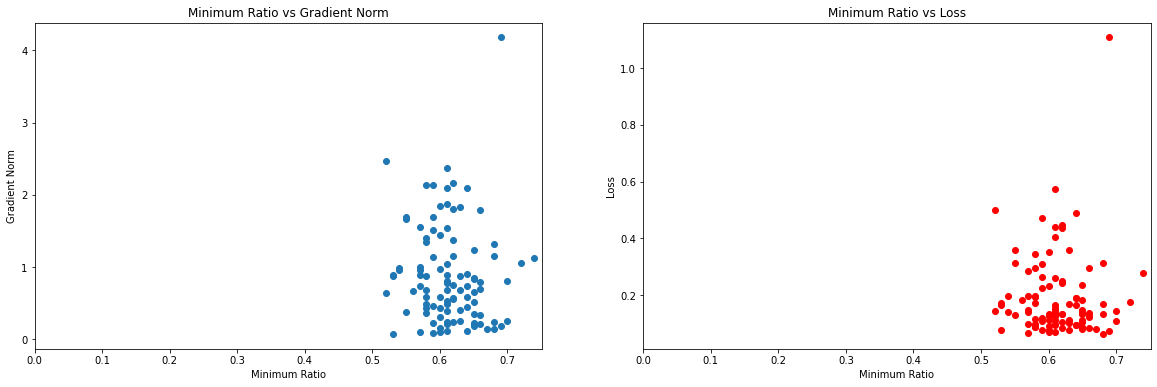

In [50]:
figure, ax = plt.subplots(1,2,figsize=(20,6))

ax[0].scatter(min_ratio_arr,grad_norm_arr)
ax[0].set_title('Minimum Ratio vs Gradient Norm')
ax[0].set_xlim(xmin=0)
ax[0].set_xlabel('Minimum Ratio')
ax[0].set_ylabel('Gradient Norm')

ax[1].scatter(min_ratio_arr,loss_arr,color='r')
ax[1].set_title('Minimum Ratio vs Loss')
ax[1].set_xlabel('Minimum Ratio')
ax[1].set_ylabel('Loss')
ax[1].set_xlim(xmin=0)

plt.show()

In [51]:
def compute_minimum_ratio_DNN(model, criterion, train, target):
    model.zero_grad()
    # compute Hessian matrix
    # save the gradient of each layer
    with autograd_lib.module_hook(save_activations):
        output = model(train)
        loss = criterion(output, target)

    # compute Hessian according to the gradient value stored in the previous step
    with autograd_lib.module_hook(compute_hess):
        autograd_lib.backward_hessian(output, loss='LeastSquares')

    layer_hess = list(hess.values())
    minimum_ratio = []

    # compute eigenvalues of the Hessian matrix
    for h in layer_hess:
        size = h.shape[0] * h.shape[1]
        h = h.reshape(size, size)
        h_eig = torch.symeig(h).eigenvalues # torch.symeig() returns eigenvalues and eigenvectors of a real symmetric matrix
        num_greater = torch.sum(h_eig > 0).item()
        minimum_ratio.append(num_greater / len(h_eig))

    ratio_mean = np.mean(minimum_ratio) # compute mean of minimum ratio

    return ratio_mean

cnn_models = [DNN1().to(device)]
loss_functions = []
optimizers = []
num_epochs = 12

for model in cnn_models:
    print(model)
    model.train()
    optimizers.append(optim.Adam(model.parameters(), lr = 0.01))
    loss_functions.append(nn.CrossEntropyLoss())
model_loss=[]
model_accuracy=[]
model_weights = []
model_grad_norms = []
min_ratio_arr = []
loss_arr = []
for model, optimizer, loss_func in zip(cnn_models,optimizers,loss_functions):
    # Train the model
    total_step = len(loaders['train'])

    train_loss =[]
    train_acc = []
    train_norm = []
    train_mr = []
    
    autograd_lib.register(model)
    
    # reset compute dictionaries
    activations = defaultdict(int)
    hess = defaultdict(float)
    
    for epoch in range(num_epochs):
        correct=0
        b_loss=[]
        b_acc=[]
        b_norm=[]
        b_mr = []
        
        for i, (images, labels) in enumerate(loaders['train']):

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images).to(device) # batch x
            b_y = Variable(labels).to(device)   # batch y
            output = model(b_x)[0]               
            loss = loss_func(output, b_y) 
                
#             # compute Hessian according to the gradient value stored in the previous step
#             with autograd_lib.module_hook(compute_hess):
#                 autograd_lib.backward_hessian(output, loss='LeastSquares')

#             layer_hess = list(hess.values())
#             minimum_ratio = []
            
#             layer_hess = list(hess.values())
#             minimum_ratio = []

#             # compute eigenvalues of the Hessian matrix
#             for h in layer_hess:
#                 size = h.shape[0] * h.shape[1]
#                 h = h.reshape(size, size)
#                 h_eig = torch.symeig(h).eigenvalues # torch.symeig() returns eigenvalues and eigenvectors of a real symmetric matrix
#                 num_greater = torch.sum(h_eig > 0).item()
#                 minimum_ratio.append(num_greater / len(h_eig))

#             ratio_mean = np.mean(minimum_ratio)
            
            # clear gradients for this training step   
            optimizer.zero_grad()  
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step() 

            predicted = torch.max(output.data, 1)[1]
            correct += (predicted==b_y).sum()

            b_loss.append(loss.detach().cpu().item())
            b_acc.append(float(correct)*100/float(100*(i+1)))
            
            grad_all = 0.0
            for p in model.parameters():
                grad=0.0
                if p.grad is not None:
                    grad = (p.grad.cpu().data.numpy() ** 2).sum()
                grad_all +=grad
            grad_norm = grad_all**0.5
            b_norm.append(grad_norm)
                    
            if (i+1)%200==0 and (epoch+1)%3==0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.3f}%'.format(epoch + 1, num_epochs, i + 1, total_step, b_loss[-1],b_acc[-1]))
        
        train_loss.append(np.average(b_loss))
        train_acc.append(np.average(b_acc))
        train_norm.append(np.average(b_norm))
        train_mr.append(np.average(b_mr))
        
    with autograd_lib.module_hook(save_activations):
        output = model(b_x)[0]               
        loss = loss_func(output, b_y) 

    # compute Hessian according to the gradient value stored in the previous step
    with autograd_lib.module_hook(compute_hess):
        autograd_lib.backward_hessian(output, loss='LeastSquares')


#     layer_hess = list(hess.values())
#     minimum_ratio = []

#     # compute eigenvalues of the Hessian matrix
#     for h in layer_hess:
#         size = h.shape[0] * h.shape[1]
#         h = h.reshape(size, size)
#         h_eig = torch.symeig(h).eigenvalues # torch.symeig() returns eigenvalues and eigenvectors of a real symmetric matrix
#         num_greater = torch.sum(h_eig > 0).item()
#         minimum_ratio.append(num_greater / len(h_eig))

#     ratio_mean = np.mean(minimum_ratio)


    model_loss.append(train_loss)
    model_accuracy.append(train_acc)
    model_grad_norms.append(train_norm)
    min_ratio_arr.append(train_mr)
    print("*"*100)

DNN1(
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)


/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch [3/12], Step [200/3000], Loss: 0.2188, Accuracy: 19.120%
Epoch [3/12], Step [400/3000], Loss: 0.0013, Accuracy: 19.135%
Epoch [3/12], Step [600/3000], Loss: 0.0031, Accuracy: 19.155%
Epoch [3/12], Step [800/3000], Loss: 0.0885, Accuracy: 19.141%
Epoch [3/12], Step [1000/3000], Loss: 0.0061, Accuracy: 19.135%
Epoch [3/12], Step [1200/3000], Loss: 0.0838, Accuracy: 19.118%
Epoch [3/12], Step [1400/3000], Loss: 0.0421, Accuracy: 19.119%
Epoch [3/12], Step [1600/3000], Loss: 0.0218, Accuracy: 19.116%
Epoch [3/12], Step [1800/3000], Loss: 0.3426, Accuracy: 19.114%
Epoch [3/12], Step [2000/3000], Loss: 0.0356, Accuracy: 19.121%
Epoch [3/12], Step [2200/3000], Loss: 0.0478, Accuracy: 19.111%
Epoch [3/12], Step [2400/3000], Loss: 1.1327, Accuracy: 19.114%
Epoch [3/12], Step [2600/3000], Loss: 0.0074, Accuracy: 19.117%
Epoch [3/12], Step [2800/3000], Loss: 0.2567, Accuracy: 19.113%
Epoch [3/12], Step [3000/3000], Loss: 0.0584, Accuracy: 19.104%
Epoch [6/12], Step [200/3000], Loss: 0.0046,

OutOfMemoryError: CUDA out of memory. Tried to allocate 143.11 GiB (GPU 0; 15.78 GiB total capacity; 2.47 GiB already allocated; 10.04 GiB free; 4.73 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

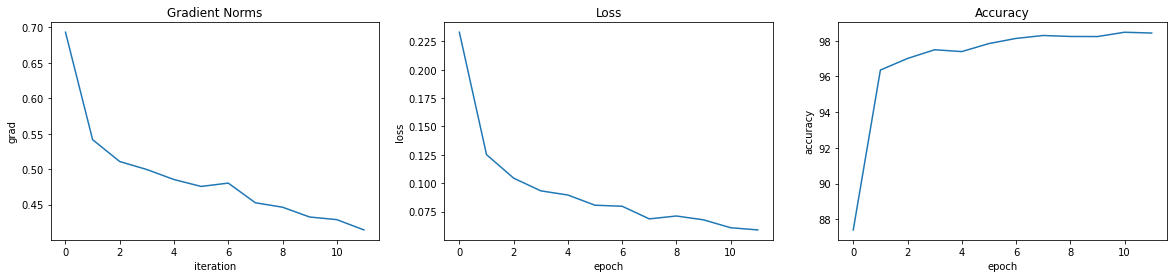

In [74]:
figure, ax= plt.subplots(1,3,figsize=(20,4))

ax[0].plot(model_grad_norms[0])
ax[0].set_title("Gradient Norms")
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("grad")

ax[1].plot(model_loss[0])
ax[1].set_title("Loss")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("loss")

ax[2].plot(model_accuracy[0])
ax[2].set_title("Accuracy")
ax[2].set_xlabel("epoch")
ax[2].set_ylabel("accuracy")

plt.show()